In [1]:
from experimenter import *
from utils import *
import pandas as pd
import numpy as np
from itertools import product
from tqdm import tqdm_notebook
from tabulate import tabulate
mcm = mixed_combinations_map
if 'HDPa' in mcm['PA']:
    mcm['PA'].remove('HDPa')
    
from matplotlib import pyplot as plt

[5, 25, 125]


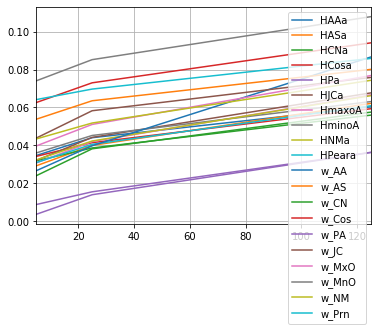

In [15]:
columns = [[y for y in mcm[x] if y.lower().endswith('a')][-1] for x in algos] + ['w_{}'.format(x) for x in algos]
nbins_dict = get_nbins_dict(lp_results['scores'][columns+['label']], columns, nbins_base=5, nbins_count = 3)
pd.DataFrame(nbins_dict).T.plot(grid = True)
# plt.title(algo)
plt.show()

[5, 25, 125]


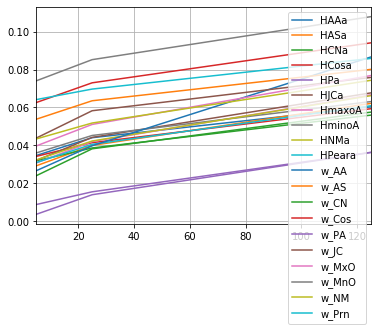

In [16]:
columns = [[y for y in mcm[x] if y.lower().endswith('a')][-1] for x in algos] + ['w_{}'.format(x) for x in algos]
nbins_dict = get_nbins_dict(lp_results['scores'][columns+['label']], columns, nbins_base=5, nbins_count = 3)
pd.DataFrame(nbins_dict).T.plot(grid = True)
# plt.title(algo)
plt.show()

In [2]:
def find_bin_new(sorted_list, bins):
    i = 0
    j = 0
#     print(all([sorted_list[i]<=sorted_list[i+1] for i in range(len(sorted_list)-1)]))
    bin_ids = []
    while i < len(sorted_list):
        ll, ul = bins[j]
        x = sorted_list[i]
        if x == 0:
            bin_ids.append(0)
            i+=1
        elif x < ul and x >= ll:
            bin_ids.append(j)
            i+=1
        else:
            if x == bins[-1][1]:
                bin_ids.append(len(bins)-1)
                i += 1
            elif x > bins[-1][1]:
                bin_ids.append(len(bins)-1)
                i+=1
            else:
                j+=1
#     print(bins)
#     print(list(sorted(set(zip(sorted_list, bin_ids)))))
    return bin_ids

In [3]:
from scipy.sparse import csr_matrix
def get_nbins_dict(df, columns, nbins_base = 3, nbins_count = 7,nbins=None):
    nbins_list = [nbins_base**i for i in range(1, 1+nbins_count)] if nbins is None else list(nbins)
    print(nbins_list)
    nbins_dict = {}
    for nbins in (nbins_list):
        col_mi_dict = {}
        for col in tqdm_notebook(columns):
            df_score = df[[col, 'label']].rename(columns = {col: 'score'})
            scores = list(df_score[df_score['score']>0]['score'])
            try:
                zero_count = df_score['score'].value_counts()[0]
            except KeyError:
                zero_count = 0
            bin_names, bin_ranges = get_log_bins(scores, nbins = nbins)
#             df_score['score'] = df_score['score'].apply(lambda s: bin_names.index(find_bin(s, bin_names, bin_ranges)))
            df_score = df_score.sort_values('score')
            df_score['score'] = find_bin_new(list(df_score['score']), bin_ranges)
            count_df = df_score.groupby(['label', 'score']).agg(len).reset_index().rename(columns = {0: 'count'})
            I = list(map(int, count_df['label']))
            J = list(map(int, count_df['score']))
            V = list(map(int, count_df['count']))
            counts = csr_matrix((V, (I, J))).todense()
            mi = get_mutual_info(counts)
            col_mi_dict[col] = mi
    #         print(col, mi)
        nbins_dict[nbins] = col_mi_dict
    return nbins_dict

In [17]:
from information_calculator import get_mutual_info
df = lp_results['scores']
colu = df.columns
from scipy.sparse import csr_matrix


for col in colu:
    if (col != 'label'):
        df_score = df[[col, 'label']].rename(columns = {col: 'score'})
        nC_0, nC_1 = df['label'].value_counts()[0], df['label'].value_counts()[1]
        count_df = df_score.groupby(['label', 'score']).agg(len).reset_index().rename(columns = {0: 'count'})
        I = list(map(int, count_df['label']))
        J = list(map(int, count_df['score']))
        V = list(map(int, count_df['count']))
        counts = csr_matrix((V, (I, J))).todense()
        print(col, get_mutual_info(counts))

AA 0.0172955012001359
AS 0.0
CN 0.02729609801825572
Cos 0.0
PA 0.21244496364977478
JC 0.0
MxO 0.0
MnO 0.0023486772701027947
NM 0.0
Prn 0.0
w_AA 0.04553306313759997
w_AS 0.0
w_CN 0.1294106043053339
w_Cos 0.0


KeyboardInterrupt: 

In [4]:
def find_bin(s, bin_names, bin_ranges):
    if s == 0:
        return bin_names[0]
    for x, rng in zip(bin_names, bin_ranges):
        if x == bin_names[-1]:
            if s >= rng[0]:
                return bin_names[-1]
        if rng[0] <= s < rng[1]:
            return x
    print('Score {} not in any bin: {}'.format(s, bin_ranges))

def get_log_bins(scores, nbins = 5):
    # plt.subplot(211)
    hist, bins = np.histogram(scores, bins=nbins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    # plt.subplot(212)
    loghist, _, = np.histogram(scores, bins=logbins)
#     logbins = bins
    # plt.xscale('log')
    # plt.show()
#     bin_names = ['z', 'vl', 'l', 'm', 'h', 'vh']
    bin_names = list(range(nbins+1))
    logbins = np.concatenate([[0], logbins])
    bin_ranges = [(logbins[i], logbins[i+1]) for i in range(len(logbins)-1)]
    return bin_names, bin_ranges

In [26]:
d=lp_results['scores']
e=lp_results1['scores']

In [27]:
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
nbins_dict=dict()
nbins_dict1=dict()

from information_calculator import get_mutual_info
algos = ['AA', 'AS', 'CN', 'Cos', 'PA', 'JC', 'MxO', 'MnO', 'NM', 'Prn']
# algos = ['AA']
print('temporal')
for algo in tqdm_notebook(algos):
    columns = ['w_{}'.format(algo)] + mcm[algo] 
    if algo == 'PA':
        columns = ['HDPa'] + columns
    nbins_dict[algo] = get_nbins_dict(d, columns, nbins_base=3, nbins_count = 7, nbins=[2000])
#     pd.DataFrame(nbins_dict).T.plot(grid = True)
#     plt.title(algo)
#     plt.show()
print('structural')
for algo in tqdm_notebook(algos):
    columns = ['w_{}'.format(algo)] + mcm[algo] 
    if algo == 'PA':
        columns = ['HDPa'] + columns
    nbins_dict1[algo] = get_nbins_dict(e, columns, nbins_base=3, nbins_count = 7, nbins=[2000])

temporal


[2000]



[2000]



[2000]



[2000]



[2000]



[2000]



[2000]



[2000]



[2000]



[2000]




structural


[2000]



[2000]



[2000]



[2000]



[2000]



[2000]



[2000]



[2000]



[2000]



[2000]


In [ ]:
# nbins_dict['Prn'][2187]
# nbins_dict

In [21]:
help(ax.legend)

Help on method legend in module matplotlib.axes._axes:

legend(*args, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Place a legend on the axes.
    
    Call signatures::
    
        legend()
        legend(labels)
        legend(handles, labels)
    
    The call signatures correspond to three different ways how to use
    this method.
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        line, = ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line, = ax.plot([1, 2, 3])
        line.set_label('Label via method')
        ax.legend()
    
    Specific lines can be excluded from the au

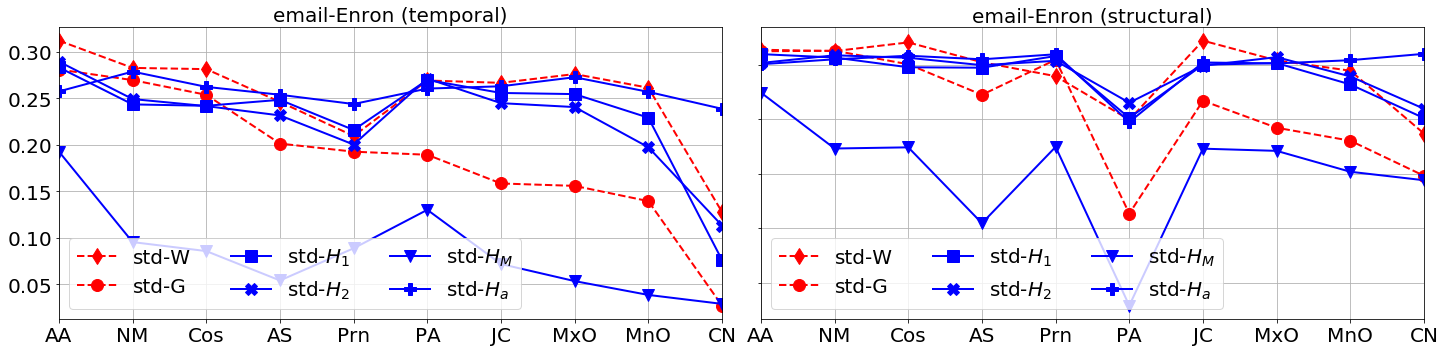

In [29]:
val=2000
x=[]
y1=[]
y2=[]
y3=[]
y4=[]
y5=[]
y6=[]
y11=[]
y21=[]
y31=[]
y41=[]
y51=[]
y61=[]
for i in algos:
    if i == 'PA':
        third = nbins_dict[i][val]['HPl1']
        fourth = nbins_dict[i][val]['HPl2']
        fifth = nbins_dict[i][val]['HPM']
        sixth = nbins_dict[i][val]['HPa']
        first = nbins_dict[i][val]['w_{}'.format(i)]
        second = nbins_dict[i][val][i]

    elif (i=='MxO'):
        third = nbins_dict[i][val]['Hmaxol1']
        fourth = nbins_dict[i][val]['Hmaxol2']
        fifth = nbins_dict[i][val]['HmaxoM']
        sixth = nbins_dict[i][val]['HmaxoA']
        first = nbins_dict[i][val]['w_{}'.format(i)]
        second = nbins_dict[i][val][i]
        
    elif (i=='MnO'):
        third = nbins_dict[i][val]['Hminol1']
        fourth = nbins_dict[i][val]['Hminol2']
        fifth = nbins_dict[i][val]['HminoM']
        sixth = nbins_dict[i][val]['HminoA']
        first = nbins_dict[i][val]['w_{}'.format(i)]
        second = nbins_dict[i][val][i]
        
    elif(i=='Prn'):
        third= nbins_dict[i][val]['HPearl1']
        fourth = nbins_dict[i][val]['HPearl2']
        fifth = nbins_dict[i][val]['HPearM']
        sixth = nbins_dict[i][val]['HPeara']
        first = nbins_dict[i][val]['w_{}'.format(i)]
        second = nbins_dict[i][val][i]
        
    else:
        third = nbins_dict[i][val]['H{}'.format(i)+'l1']       
        first = nbins_dict[i][val]['w_{}'.format(i)]
        second = nbins_dict[i][val][i]
        fourth = nbins_dict[i][val]['H{}'.format(i)+'l2']
        fifth = nbins_dict[i][val]['H{}'.format(i)+'M']
        sixth = nbins_dict[i][val]['H{}'.format(i)+'a']

    x.append(i)
    y1.append(first)
    y2.append(second)
    y3.append(third)
    y4.append(fourth)
    y5.append(fifth)
    y6.append(sixth)
    
for i in algos:
    if i == 'PA':
        third1 = nbins_dict1[i][val]['HPl1']
        fourth1 = nbins_dict1[i][val]['HPl2']
        fifth1 = nbins_dict1[i][val]['HPM']
        sixth1 = nbins_dict1[i][val]['HPa']
        first1 = nbins_dict1[i][val]['w_{}'.format(i)]
        second1 = nbins_dict1[i][val][i]
        
    elif (i=='MxO'):
        third1 = nbins_dict1[i][val]['Hmaxol1']
        fourth1 = nbins_dict1[i][val]['Hmaxol2']
        fifth1 = nbins_dict1[i][val]['HmaxoM']
        sixth1 = nbins_dict1[i][val]['HmaxoA']
        first1 = nbins_dict1[i][val]['w_{}'.format(i)]
        second1 = nbins_dict1[i][val][i]
        
    elif (i=='MnO'):
        third1 = nbins_dict1[i][val]['Hminol1']
        fourth1 = nbins_dict1[i][val]['Hminol2']
        fifth1 = nbins_dict1[i][val]['HminoM']
        sixth1 = nbins_dict1[i][val]['HminoA']
        first1 = nbins_dict1[i][val]['w_{}'.format(i)]
        second1 = nbins_dict1[i][val][i]
        
    elif(i=='Prn'):
        third1= nbins_dict1[i][val]['HPearl1']
        fourth1 = nbins_dict1[i][val]['HPearl2']
        fifth1 = nbins_dict1[i][val]['HPearM']
        sixth1 = nbins_dict1[i][val]['HPeara']
        first1 = nbins_dict1[i][val]['w_{}'.format(i)]
        second1 = nbins_dict1[i][val][i]
        
    else:
        third1 = nbins_dict1[i][val]['H{}'.format(i)+'l1']
        first1 = nbins_dict1[i][val]['w_{}'.format(i)]
        second1 = nbins_dict1[i][val][i]
        fourth1 = nbins_dict1[i][val]['H{}'.format(i)+'l2']
        fifth1 = nbins_dict1[i][val]['H{}'.format(i)+'M']
        sixth1 = nbins_dict1[i][val]['H{}'.format(i)+'a']
        first1 = nbins_dict1[i][val]['w_{}'.format(i)]
        second1 = nbins_dict1[i][val][i]
        
    y11.append(first1)
    y21.append(second1)
    y31.append(third1)
    y41.append(fourth1)
    y51.append(fifth1)
    y61.append(sixth1)

yy=pd.DataFrame(zip(*[x,y1,y2,y3,y4,y5,y6]),columns=['Algo','std-W','std-G','std-$H_1$','std-$H_2$','std-$H_M$','std-$H_a$'], index=x)
yy1=pd.DataFrame(zip(*[x,y11,y21,y31,y41,y51,y61]),columns=['Algo','std-W','std-G','std-$H_1$','std-$H_2$','std-$H_M$','std-$H_a$'], index=x)

fig, ax = plt.subplots(figsize=(20, 5))

ax = plt.subplot(1, 2, 1)
yy = yy.sort_values('std-G', ascending = False)
yy.plot(kind='line',grid = True, style=['rd--','ro--','bs-','bX-','bv-','bP-'], lw=2, ax=ax, markersize=12)
ax.tick_params(labelsize=20)
ax.legend(prop={'size': 20}, ncol=3)
plt.title(data_name+" (temporal)",fontsize=20)

ax = plt.subplot(1, 2, 2)

yy1.loc[yy.index, :].plot(kind='line',grid = True, style=['rd--','ro--','bs-','bX-','bv-','bP-'], lw=2, ax=ax, sharey = True, markersize=12)
ax.tick_params(labelsize=20)
ax.legend(prop={'size': 20}, ncol = 3)
ax = plt.subplot(1, 2, 2)
# plt.xlabel(x)
# ax.set(x)
plt.tight_layout()
plt.title(data_name+" (structural)",fontsize=20)
plt.savefig("str_tem_mutual_info.png")
plt.show()


In [ ]:
#scatter plot

In [ ]:
!pip install seaborn

In [ ]:
required_x[required_x!=0].dropna()

In [ ]:
import seaborn as sns
for c in mcm['AA'][4:5]:
    scores = scores_df[scores_df[c] > 0][c].copy(deep=True)
    labels = scores_df[scores_df[c] > 0]['label'].copy(deep=True)
    _max = scores.max()
    _min = scores.min()
    scores = (scores - _min)/(_max - _min)
    pos = scores[labels==1].dropna()
    neg = scores[labels==0].dropna()
    lm = sns.distplot(pos, hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    lm = sns.distplot(neg, hist=False, kde=True, 
             bins=int(180/5), color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
lm.axes.set_xlim(0,)


In [ ]:
from sklearn.metrics import roc_curve, auc
plt.figure()
for c in mcm['PA']:
    fpr, tpr, _ = roc_curve(scores_df['label'], scores_df[c])
    roc_auc = auc(fpr, tpr)
    lw = 2
    plt.plot(fpr, tpr,
             lw=lw, label='ROC curve for {} (area = {})'.format(c, round(roc_auc, 2)))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [10]:
output = perform_classification(data_params, lp_data_params, lp_params, classifier_params, iter_var=0)

Predictor:   0%|          | 0/18 [00:00<?, ?it/s]

READING DATASET...
PREPARING LP DATA...
Going for a structural split
Converting S to A
STEP 1: Computing SS^T
STEP 3: Setting diagonals to 0
STEP 4: Eliminating zeros
Splitting into train/test...
STEP 1: Sampling test edges...
STEP 2: Preparing test data...
Filling in A_test...
STEP 3: Preparing train data...
Filling in A_train...
Generating negative patterns until 1440 are found
Converting incidence matrix to hyperedge <class 'set'> for faster processing...
Precomputing node-hyperneighbor map...
Splitting hyperedges and getting S_train...
LP DATA STATS: S_train.shape = (148, 1859), A_test.nnz = 576
PERFORMING LINK PREDICTION...
Preparing predictor AA
Performing prediction...


Predictor:   6%|▌         | 1/18 [00:00<00:08,  1.89it/s]

Done
Preparing predictor AS
Performing prediction...


Predictor:  11%|█         | 2/18 [00:01<00:08,  1.94it/s]

Done
Preparing predictor CN
Performing prediction...
Done
Preparing predictor Comm
Performing prediction...
predict() got an unexpected keyword argument 'weight'


ImportError: Module 'community' could not be found. Please install python-louvain from https://bitbucket.org/taynaud/python-louvain

In [41]:
lp_params['linkpred_indices']=[0, 1, 2, 5, 6, 8, 10, 11, 12, 13]
lp_params['hypergraph_score_indices']=[8, 9, 11, 12, 30, 31, 33, 34, 52, 53, 55, 56, 37, 38, 40, 41, 14, 16, 17, 19, 20, 1, 2, 4, 5, 66, 67, 69, 70, 59, 60, 62, 63, 44, 45, 47, 48, 23, 24, 26, 27]

In [24]:
params = get_default_params()
data_name = 'email-Enron'
split_mode = 'structural'
params['data_params']['data_name'] = data_name
params['data_params']['split_mode'] = split_mode
# params

In [25]:
temp , lp_results1 = perform_link_prediction(params['data_params'], params['lp_data_params'],
                                        params['lp_params'],1)

In [97]:
scores_df=lp_results['scores']

In [98]:
G_feats = default_lp_cols
W_feats = ['w_{}'.format(c) for c in default_lp_cols]
H_feats = default_hyper_cols

In [99]:
out=perform_GWH_classification(params, G_feats, W_feats, H_feats, 'xgboost')

In [100]:
df1=pd.DataFrame(out[tuple(G_feats)]['test_scores'].rename(columns = {'xgboost_test':'mac-G'}))
df2=scores_df['label']
# out[tuple(G_feats)]['test_scores']
# out
df3=pd.DataFrame(out[tuple(H_feats)]['test_scores'].rename(columns = {'xgboost_test':'mac-H'}))
df4=pd.DataFrame(out[tuple(W_feats)]['test_scores'].rename(columns = {'xgboost_test':'mac-W'}))
df5=pd.DataFrame(out[tuple(G_feats+H_feats)]['test_scores'].rename(columns = {'xgboost_test':'mac-GH'}))
df6=pd.DataFrame(out[tuple(W_feats+H_feats)]['test_scores'].rename(columns = {'xgboost_test':'mac-WH'}))

In [101]:
df7=df1.merge(df2, left_index=True,right_index=True)
df8=df7.merge(df3, left_index=True,right_index=True)
df9=df8.merge(df4, left_index=True,right_index=True)
df10=df9.merge(df5, left_index=True,right_index=True)
df=df10.merge(df6, left_index=True,right_index=True)

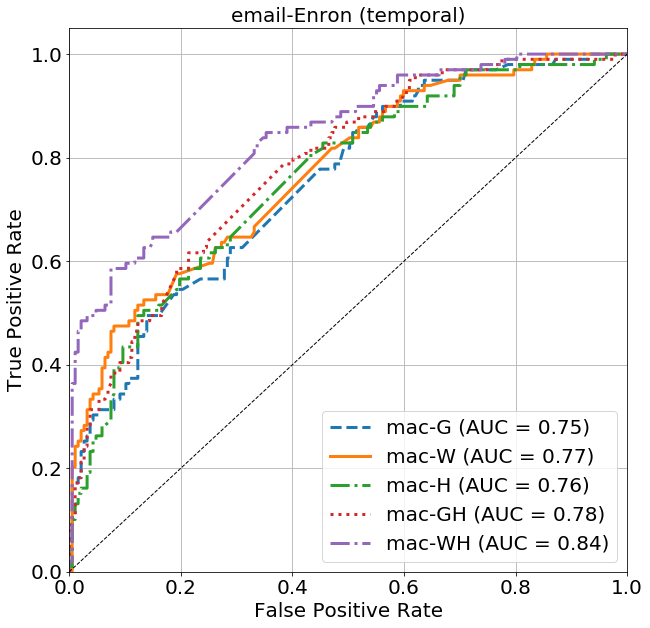

In [138]:
from sklearn.metrics import roc_curve, auc
fig, ax = plt.subplots(figsize = (10, 10))
# plt.figure()
col=['mac-G','mac-W','mac-H','mac-GH','mac-WH']
arr=['dashed','solid','dashdot','dotted','-.']
i=0
for c in col:
    fpr, tpr, _ = roc_curve(df['label'], df[c])
    roc_auc = auc(fpr, tpr)
    lw = 2
    ax.plot(fpr, tpr,
             lw=3, label='{} (AUC = {})'.format(c, round(roc_auc, 2)),linestyle=arr[i])
    i=i+1

ax.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
# ax.
plt.title('email-Enron (temporal)', fontsize = 20)
plt.legend(loc="lower right", prop={'size': 20})
plt.tick_params(labelsize=20)
# plt.label_params(labelsize=20)
plt.grid(True)
plt.savefig("email-Enron_temporal.png")
plt.show()

In [109]:
params['data_params']['split_mode']='structural'


In [110]:
temp1 , lp_results1 = perform_link_prediction(params['data_params'], params['lp_data_params'],
                                        params['lp_params'],1)

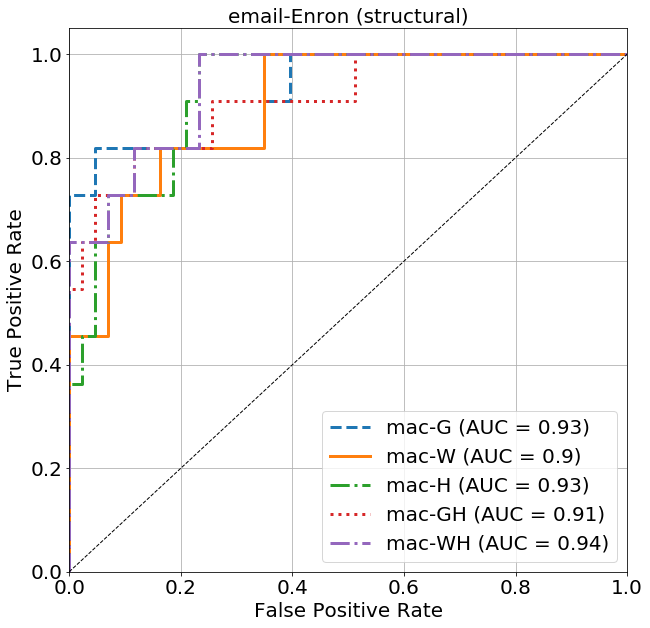

In [139]:
#output1 = perform_classification(data_params, lp_data_params, lp_params, classifier_params, iter_var=0)
lp_params['linkpred_indices']=[0, 1, 2, 5, 6, 8, 10, 11, 12, 13]
lp_params['hypergraph_score_indices']=[8, 9, 11, 12, 30, 31, 33, 34, 52, 53, 55, 56, 37, 38, 40, 41, 14, 16, 17, 19, 20, 1, 2, 4, 5, 66, 67, 69, 70, 59, 60, 62, 63, 44, 45, 47, 48, 23, 24, 26, 27]
G_feats = default_lp_cols
W_feats = ['w_{}'.format(c) for c in default_lp_cols]
H_feats = default_hyper_cols
out1=perform_GWH_classification(params, G_feats, W_feats, H_feats, 'xgboost')
df11=pd.DataFrame(out1[tuple(G_feats)]['test_scores'].rename(columns = {'xgboost_test':'mac-G'}))
df21=lp_results1['scores']['label']
# out[tuple(G_feats)]['test_scores']
# out
df31=pd.DataFrame(out1[tuple(H_feats)]['test_scores'].rename(columns = {'xgboost_test':'mac-H'}))
df41=pd.DataFrame(out1[tuple(W_feats)]['test_scores'].rename(columns = {'xgboost_test':'mac-W'}))
df51=pd.DataFrame(out1[tuple(G_feats+H_feats)]['test_scores'].rename(columns = {'xgboost_test':'mac-GH'}))
df61=pd.DataFrame(out1[tuple(W_feats+H_feats)]['test_scores'].rename(columns = {'xgboost_test':'mac-WH'}))
df71=df11.merge(df21, left_index=True,right_index=True)
df81=df71.merge(df31, left_index=True,right_index=True)
df91=df81.merge(df41, left_index=True,right_index=True)
df101=df91.merge(df51, left_index=True,right_index=True)
dff1=df101.merge(df61, left_index=True,right_index=True)
from sklearn.metrics import roc_curve, auc
fig, ax = plt.subplots(figsize = (10, 10))
col=['mac-G','mac-W','mac-H','mac-GH','mac-WH']
arr=['dashed','solid','dashdot','dotted','-.']
i=0
for c in col:
    fpr, tpr, _ = roc_curve(dff1['label'], dff1[c])
    roc_auc = auc(fpr, tpr)
    lw = 2
    plt.plot(fpr, tpr,
             lw=3, label='{} (AUC = {})'.format(c, round(roc_auc, 2)),linestyle=arr[i])
    i=i+1

ax.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('email-Enron (structural)', fontsize = 20)
plt.legend(loc="lower right", prop={'size': 20})
plt.tick_params(labelsize=20)
plt.grid(True)
plt.savefig("email-Enron_structural.png")

plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
plt.figure()
for c in [G_feats, W_feats, H_feats, G_feats+H_feats, W_feats+H_feats]:
    fpr, tpr, _ = roc_curve(scores_df['label'], scores_df[c])
    roc_auc = auc(fpr, tpr)
    lw = 2
    plt.plot(fpr, tpr,
             lw=lw, label='ROC curve for {} (area = {})'.format(c, round(roc_auc, 2)))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

[5, 25, 125, 625, 3125]


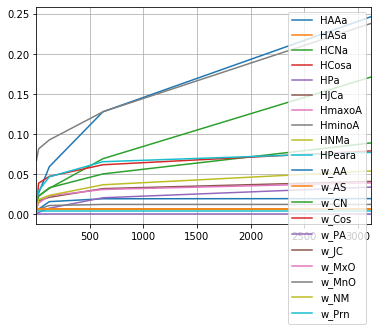

In [ ]:
pd.DataFrame(nbins_dict).T.plot(grid = True, xlim = (0, 100))


In [30]:
import numpy as np

from scipy.special import gamma,psi
from scipy import ndimage
from scipy.linalg import det
from numpy import pi

from sklearn.neighbors import NearestNeighbors

__all__=['entropy', 'mutual_information', 'entropy_gaussian']

EPS = np.finfo(float).eps


def nearest_distances(X, k=1):

    knn = NearestNeighbors(n_neighbors=k + 1)
    knn.fit(X)
    d, _ = knn.kneighbors(X) # the first nearest neighbor is itself
    return d[:, -1] # returns the distance to the kth nearest neighbor


def entropy_gaussian(C):
    '''
    Entropy of a gaussian variable with covariance matrix C
    '''
    if np.isscalar(C): # C is the variance
        return .5*(1 + np.log(2*pi)) + .5*np.log(C)
    else:
        n = C.shape[0] # dimension
        return .5*n*(1 + np.log(2*pi)) + .5*np.log(abs(det(C)))


def entropy(X, k=1):
 
    r = nearest_distances(X, k) # squared distances
    n, d = X.shape
    volume_unit_ball = (pi**(.5*d)) / gamma(.5*d + 1)
    return (d*np.mean(np.log(r + np.finfo(X.dtype).eps))
            + np.log(volume_unit_ball) + psi(n) - psi(k))


def mutual_information(variables, k=1):
    '''
    Returns the mutual information between any number of variables.
    Each variable is a matrix X = array(n_samples, n_features)
    where
      n = number of samples
      dx,dy = number of dimensions
    Optionally, the following keyword argument can be specified:
      k = number of nearest neighbors for density estimation
    Example: mutual_information((X, Y)), mutual_information((X, Y, Z), k=5)
    '''
    if len(variables) < 2:
        raise AttributeError(
                "Mutual information must involve at least 2 variables")
    all_vars = np.hstack(variables)
    return (sum([entropy(X, k=k) for X in variables])
            - entropy(all_vars, k=k))


def mutual_information_2d(x, y, sigma=1, normalized=False):

    bins = (256, 256)

    jh = np.histogram2d(x, y, bins=bins)[0]

    ndimage.gaussian_filter(jh, sigma=sigma, mode='constant',
                                 output=jh)

    jh = jh + EPS
    sh = np.sum(jh)
    jh = jh / sh
    s1 = np.sum(jh, axis=0).reshape((-1, jh.shape[0]))
    s2 = np.sum(jh, axis=1).reshape((jh.shape[1], -1))

    if normalized:
        mi = ((np.sum(s1 * np.log(s1)) + np.sum(s2 * np.log(s2)))
                / np.sum(jh * np.log(jh))) - 1
    else:
        mi = ( np.sum(jh * np.log(jh)) - np.sum(s1 * np.log(s1))
               - np.sum(s2 * np.log(s2)))

    return mi

In [37]:
df_score = np.array(e[['CN', 'label']].rename(columns = {col: 'score'}))
df_score

array([[11.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       ...,
       [ 5.,  1.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [40]:
mutual_information_2d(np.array(e[['CN']]).ravel(),np.array(e[['label']]).ravel())

0.2127591288354842